In [36]:
'''模型选择'''

'模型选择'

# 模型
- 训练误差：模型在训练数据上的误差
- 泛化误差：模型在新数据上的误差
- 验证数据集： 用来评估模型好坏的数据集，选择模型，选择超参数
- 测试数据集：只用一次的数据集
> 验证数据集和训练数据集一定不能有交叉混合，
> 不能将测试数据集和验证数据集混合，测试只能用一次，不能用来调超参数，验证数据集可以用多次，用来选择模型、超参数

- K折交叉验证：切成K块，进行K次训练（每次用i号作为验证，剩下的用来训练），最后报告K个验证集平均误差
|   |简单  | 复杂|
|低 |正常  |欠拟合|
|高 |过拟合|正常  |



In [37]:
'''多项式回归
探索拟合概念
'''
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, 0.1^2)$生成训练和测试数据标签。阶乘避免非常大的梯度值或损失之，为训练集和测试集各生成100个样本

In [38]:
'''生成数据集'''
max_degree = 20 # 多项式最大阶数
n_train, n_test = 100,100 # 训练和测试集大小
true_w = np.zeros(max_degree) # 分配大量空间
true_w[0:4] = np.array([5, 1, 2, -3.4]) # 真实参数

features = np.random.normal(size=(n_train+n_test, 1)) # 生成x的值，符合标准正态分布
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # 对features中的每个元素，依次生成它的0次方...19次方，形成一个多项式特征数组 （200，20）

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1) # 除阶乘
    
# labels的维度：(n_train+n_test)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(loc=0, scale=0.1, size=(labels.shape)) # 完成生成训练集和测试集的数据


In [39]:
'''将上面的numpy array类型的数据转换成tensor'''
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]] # 学习这种写法


In [40]:
'''评估损失用的函数'''
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2) # 损失综合，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1] # 返回对于样本数量的平均损失
    

In [60]:
'''定义训练函数'''
def train(train_features, test_features, train_labels, test_labels, num_epochs = 400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，多项式中已经实现了
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr = 0.01) # 随机梯度下降是一种优化算法
    animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight', net[0].weight.data.numpy())
    
    

weight [[ 5.00177    1.0023175  2.0069966 -3.4027019]]


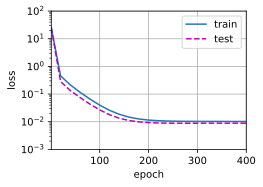

In [61]:
'''三阶多项式函数拟合（正常）
从多项式特征中选择前4个维度，即1，2，x^2/2!，x^3/3!
'''
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight [[ 5.7836213  -0.30744404]]


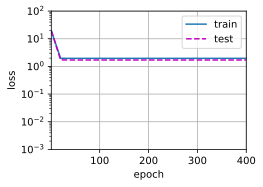

In [62]:
'''线性函数拟合（欠拟合）
'''
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight [[ 5.0168276e+00  9.5845139e-01  1.9247575e+00 -3.1159406e+00
   2.2245210e-01 -9.4590735e-01  1.0346744e-01 -1.2755851e-01
   1.2843587e-01  1.3761166e-01 -1.7257531e-01  9.7636327e-02
   9.2807665e-02 -8.2870103e-02 -1.4315552e-02  1.7028652e-01
  -4.9898666e-03  3.4932058e-02  2.1011259e-01  1.5756993e-01]]


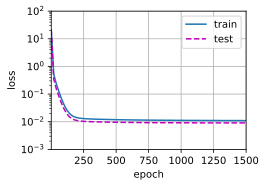

In [63]:
'''高阶多项式函数拟合（过拟合）
过于复杂的模型会轻易受到训练数据中噪声的影响
'''
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)